In [1]:
import os
import sys
import re
import matplotlib
import pandas as pd
import numpy as np
from os.path import splitext
import ipaddress as ip
import tldextract
import whois
import datetime
import time
from urlparse import *

In [2]:
%pwd

u'/home/lam/Projects/URL/URL712'

In [3]:
df_train = pd.read_csv('../data/train_500000.txt', sep='\t', header=None, names=['label', 'url'])
df_test = pd.read_csv('../data/train_500000.txt', sep='\t', header=None, names=['label', 'url'])

# malwaredomains.com
df_domain = pd.read_csv('../data/domains.txt')['domain']

# https://www.symantec.com/blogs/feature-stories/top-20-shady-top-level-domains
df_tld = pd.read_csv('../data/tld.txt',header=None)

for d in [df_train, df_test, df_domain, df_tld]:
    print(d.shape)
    print(d.head())
    
print(df_train[df_train['label']==1].shape)
print(df_train[df_train['label']!=1].shape)

(500000, 2)
   label                                                url
0      1  http://www.jiehun.cn/hunyan/jd.php?qy=a?aa???a...
1      1  http://telugumasthii.blogspot.mx/2012/09/blog-...
2      1  http://flatmela.com/properties/1100-sq-ft-apar...
3      1  http://13453765871837679316.googlegroups.com/a...
4      1                    http://base-send-exact.website/
(500000, 2)
   label                                                url
0      1  http://www.jiehun.cn/hunyan/jd.php?qy=a?aa???a...
1      1  http://telugumasthii.blogspot.mx/2012/09/blog-...
2      1  http://flatmela.com/properties/1100-sq-ft-apar...
3      1  http://13453765871837679316.googlegroups.com/a...
4      1                    http://base-send-exact.website/
(26943,)
0              amazon.co.uk.security-check.ga
1                     autosegurancabrasil.com
2    dadossolicitado-antendimento.sad879.mobi
3                              hitnrun.com.my
4         maruthorvattomsrianjaneyatemple.org
Name: domain, dty

Hackers can use long URL to hide the doubtful part in the address bar. For example: 
http://federmacedoadv.com.br/3f/aze/ab51e2e319e51502f416dbe46b773a5e/?cmd=_home&amp;dispatch=11004d58f5b74f8dc1e7c2e8dd4105e811004d58f5b74f8dc1e7c2e8dd4105e8@phishing.website.html



In [4]:
def count_dots(url):  
    return url.count('.')

def count_delim(url):
    count = 0
    delim=[';','_','?','=','&']
    for u in url:
        if u in delim:
            count += 1
    
    return count

If an IP address is used as an alternative of the domain name in the URL, such as “http://125.98.3.123/fake.html”, users can be sure that someone is trying to steal their personal information. Sometimes, the IP address is even transformed into hexadecimal code as shown in the following link “http://0x58.0xCC.0xCA.0x62/2/paypal.ca/index.html”. 

In [5]:
def is_ip(url):
    return 0
#     try:
#         if ip.ip_address(url):
#             return 1
#     except:
#         return 0

#     try:
#         if ip.IPv4Network(url):
#             return 1
# #     except ValueError:    
#     except:
#         return 0
# #         print('address/netmask is invalid for IPv4:', address)

def count_hyphens(url):
    return url.count('-')   

def Check_IPaddress(tokens_words):

    cnt=0;
    for ele in tokens_words:
        if unicode(ele).isnumeric():
            cnt+=1
        else:
            if cnt>=4 :
                return 1
            else:
                cnt=0;
    if cnt>=4:
        return 1
    return 0

In [6]:
print(is_ip('www.yahoo.com'))
print(is_ip('http://192.168.1.11/'))
print(Check_IPaddress('www.yahoo.com'))
print(Check_IPaddress('192.168.1.11'))

0
0
0
0


Using “@” symbol in the URL leads the browser to ignore everything preceding the “@” symbol and the real address often follows the “@” symbol. 

In [7]:
def count_at(url):
    return url.count('@')

The existence of “//” within the URL path means that the user will be redirected to another website. An example of such URL’s is: “http://www.legitimate.com//http://www.phishing.com”. We examine the presence of “//”

In [8]:
def count_dslash(url):
    return url.count('//')

def count_subdir(url):
    return url.count('/')

def get_ext(url):
    """Return the filename extension from url, or ''."""   
    _ , ext = splitext(url)
    return ext

def count_subdomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))

def count_queries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

def bad_tld(tld):
    return 1 if df_tld.isin([tld]).any().bool() == True else 0

print(bad_tld('kim'))
print(bad_tld('country'))
print(bad_tld('county'))

def bad_domain(domain):
    return 1 if df_domain.isin([domain]).any() == True else 0

print(bad_domain('hit'))
print(bad_domain('hitnrun.com'))
print(bad_domain('hitnrun.com.my'))

1
1
0
0
0
1


In [9]:
'''
featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','create_age(months)','expiry_age(months)','update_age(days)','country','file extension','label'))'''

features_col = ['url','num dots','num hyphen','len url','num at',\
                'num double slash','num subdir','num subdomain',\
                'len domain','len queries','is IP','bad TLD',\
                'bad domain','label']

In [10]:
def get_features(url, label):
    
    url = str(url)
    url_len = len(url)
 
    #parse the URL and extract the domain information

    # >>> o = urlparse('http://www.cwi.nl:80/%7Eguido/Python.html')
    # >>> o   
    # ParseResult(scheme='http', netloc='www.cwi.nl:80', path='/%7Eguido/Python.html',
    #             params='', query='', fragment='')
    o = urlparse(url)
    
    # >>> ext = tldextract.extract('http://forums.bbc.co.uk')
    # >>> (ext.subdomain, ext.domain, ext.suffix)
    # ('forums', 'bbc', 'co.uk')
    ext = tldextract.extract(url)

    isip = is_ip(ext.domain)
    
    #number of dots in subdomain
    num_dots = count_dots(ext.subdomain)
    
    #number of sub domain    
    num_subdomain = count_subdomain(ext.subdomain)
    
    #hyphens in domain   
    num_hyphens = count_hyphens(o.netloc)
    
    # @ in the url    
    num_at = count_at(o.netloc)
    
    #length of domain name    
    len_domain = len(o.netloc)  
    
    #number of double slash    
    num_dslash = count_dslash(o.path)
    
    #number of subdir    
    num_subdir = count_subdir(o.path)    
    
    extension = get_ext(o.path)
    
    #length of queries    
    len_query = len(o.query)
        
    #presence of suspicious TLD
    sus_TLD = bad_tld(ext.suffix)
        
    #presence of suspicious domain
#     sus_domain = 1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 
    sus_domain = bad_domain('.'.join(ext[1:]))
              
    return pd.DataFrame([[url, num_dots, num_hyphens, url_len, num_at, num_dslash, \
            num_subdir, num_subdomain, len_domain, len_query, isip, \
            sus_TLD, sus_domain, str(label)]], columns=features_col)

In [11]:
extbbc = tldextract.extract('http://forums.bbc.co.uk')
print(extbbc)
print('.'.join(extbbc[1:]))

ExtractResult(subdomain='forums', domain='bbc', suffix='co.uk')
bbc.co.uk


In [12]:
def perform_extraction(df_t, features_col):
    
    df_f = pd.DataFrame(columns=features_col)
    
    start = time.time()
    for i in range(1, len(df_t), 500):

        a = get_features(df_t['url'].iloc[i],df_t['label'].iloc[i] )
        df_f = df_f.append(a)

    end = time.time()
    print('Run time: {0:.3f} s'.format(end - start))
    
    return df_f

def make_ndir():
    # target_path = str(datetime.datetime.now())
    target_path = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    if not os.path.exists(target_path):
        os.mkdir(target_path)

    os.chdir(target_path)
    os.getcwd()

make_ndir()
df_features = perform_extraction(df_train, features_col)
df_features.to_csv("train_features.csv")

Run time: 2.881 s


In [13]:
df_features[df_features['bad TLD']!=0].head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label
0,http://ajzhfhakxmrxap.bruise-besides.top/,0,1,41,0,0,1,1,33,0,0,1,0,1
0,http://0800bet.xyz/458/viewspace-479.html,0,0,41,0,0,2,0,11,0,0,1,0,1
0,http://www.freebye.win/f6b0fe96-779f-42fe-938c...,0,0,110,0,0,1,1,15,50,0,1,0,-1
0,http://vantech.pro/vi/contact,0,0,29,0,0,2,0,11,0,0,1,0,-1
0,http://m2ix.top/,0,0,16,0,0,1,0,8,0,0,1,0,-1


In [14]:
df_features[df_features['bad domain']!=0].head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label
0,http://cq850.com/?CBUEK=0012646771424419703.html,0,0,48,0,0,1,0,9,30,0,0,1,1
0,http://www.ecole-saint-simon.net/index_top/log...,0,2,72,0,0,2,1,25,20,0,0,1,1


In [15]:
df_features[df_features['num dots']!=0].sort_values('num dots', ascending=False).head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label
0,http://www.marriott.hotels.in.lake.harmony.pa....,6,2,103,0,0,1,7,61,0,0,0,0,-1
0,http://www.how.do.you.become.diabetic.iidiabet...,5,0,114,0,0,3,6,45,0,0,0,0,-1
0,http://192.168.37.254.ipaddress.com/,3,0,36,0,0,1,4,28,0,0,0,0,-1
0,http://0-www.sciencedirect.com.opac.postech.ac...,3,1,172,0,0,5,4,42,78,0,0,0,-1
0,http://165.254.34.208.ipaddress.com/,3,0,36,0,0,1,4,28,0,0,0,0,-1


In [16]:
df_features[df_features['num at']!=0].head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label


In [17]:
# df_features[df_features['num hyphen']!=0]
df_features[df_features['num double slash']!=0].head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label


In [18]:
df_features[df_features['num subdir']!=0].head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label
0,http://telugumasthii.blogspot.mx/2012/09/blog-...,0,0,60,0,0,3,1,25,0,0,0,0,1
0,http://128531.syscarewarning.info/f.html?,0,0,41,0,0,1,1,26,0,0,0,0,1
0,http://hysyz.com/item/2199.aspx,0,0,31,0,0,2,0,9,0,0,0,0,1
0,http://jiehun.cn/hunyan/jd.php?qy=a?aA?A?A?A%E...,0,0,58,0,0,2,0,9,27,0,0,0,1
0,http://mjqsyyey.mzedu.com/,0,0,26,0,0,1,1,18,0,0,0,0,1


In [19]:
df_features[df_features['num subdomain']>1].head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label
0,http://soft.dl.gezila.com/?/87173/gezila/?????...,1,0,107,0,0,1,2,18,80,0,0,0,1
0,http://r.contact.idexlab.fr/click/y764pxsw7re3...,1,0,52,0,0,2,2,20,0,0,0,0,-1
0,http://usb-bochum.de.pagesstudy.com/,1,1,36,0,0,1,2,28,0,0,0,0,-1
0,http://www.laborstudiesandresearch.ext.wvu.edu...,2,0,64,0,0,3,3,39,0,0,0,0,-1
0,http://www.dsnovagenerace.wz.cz/,1,0,32,0,0,1,2,24,0,0,0,0,-1


In [20]:
df_features[df_features['len queries']!=0].sort_values('len queries').head()

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label
0,http://www.imed.ro/forum/viewtopic.php?t=474,0,0,44,0,0,2,1,11,5,0,0,0,-1
0,https://patagonia.122.2o7.net/b/ss/patagoniav2...,1,0,89,0,0,6,2,21,5,0,0,0,-1
0,http://www.silva-gmbh.ch/?p=858,0,1,31,0,0,1,1,17,5,0,0,0,-1
0,http://cs.hyundaicard.com/?m=csFY,0,0,33,0,0,1,1,18,6,0,0,0,-1
0,http://www.espacexxx.be/?p=3267,0,0,31,0,0,1,1,16,6,0,0,0,1


In [21]:
df_features[df_features['is IP']!=0].sort_values('is IP', ascending=False).head(10)

,url,num dots,num hyphen,len url,num at,num double slash,num subdir,num subdomain,len domain,len queries,is IP,bad TLD,bad domain,label


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
from __future__ import division

/home/lam/anaconda2/envs/URL712_py3/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/lam/anaconda2/envs/URL712_py3/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lam/anaconda2/envs/URL712_py3/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lam/anaconda2/envs/URL712_py3/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value 

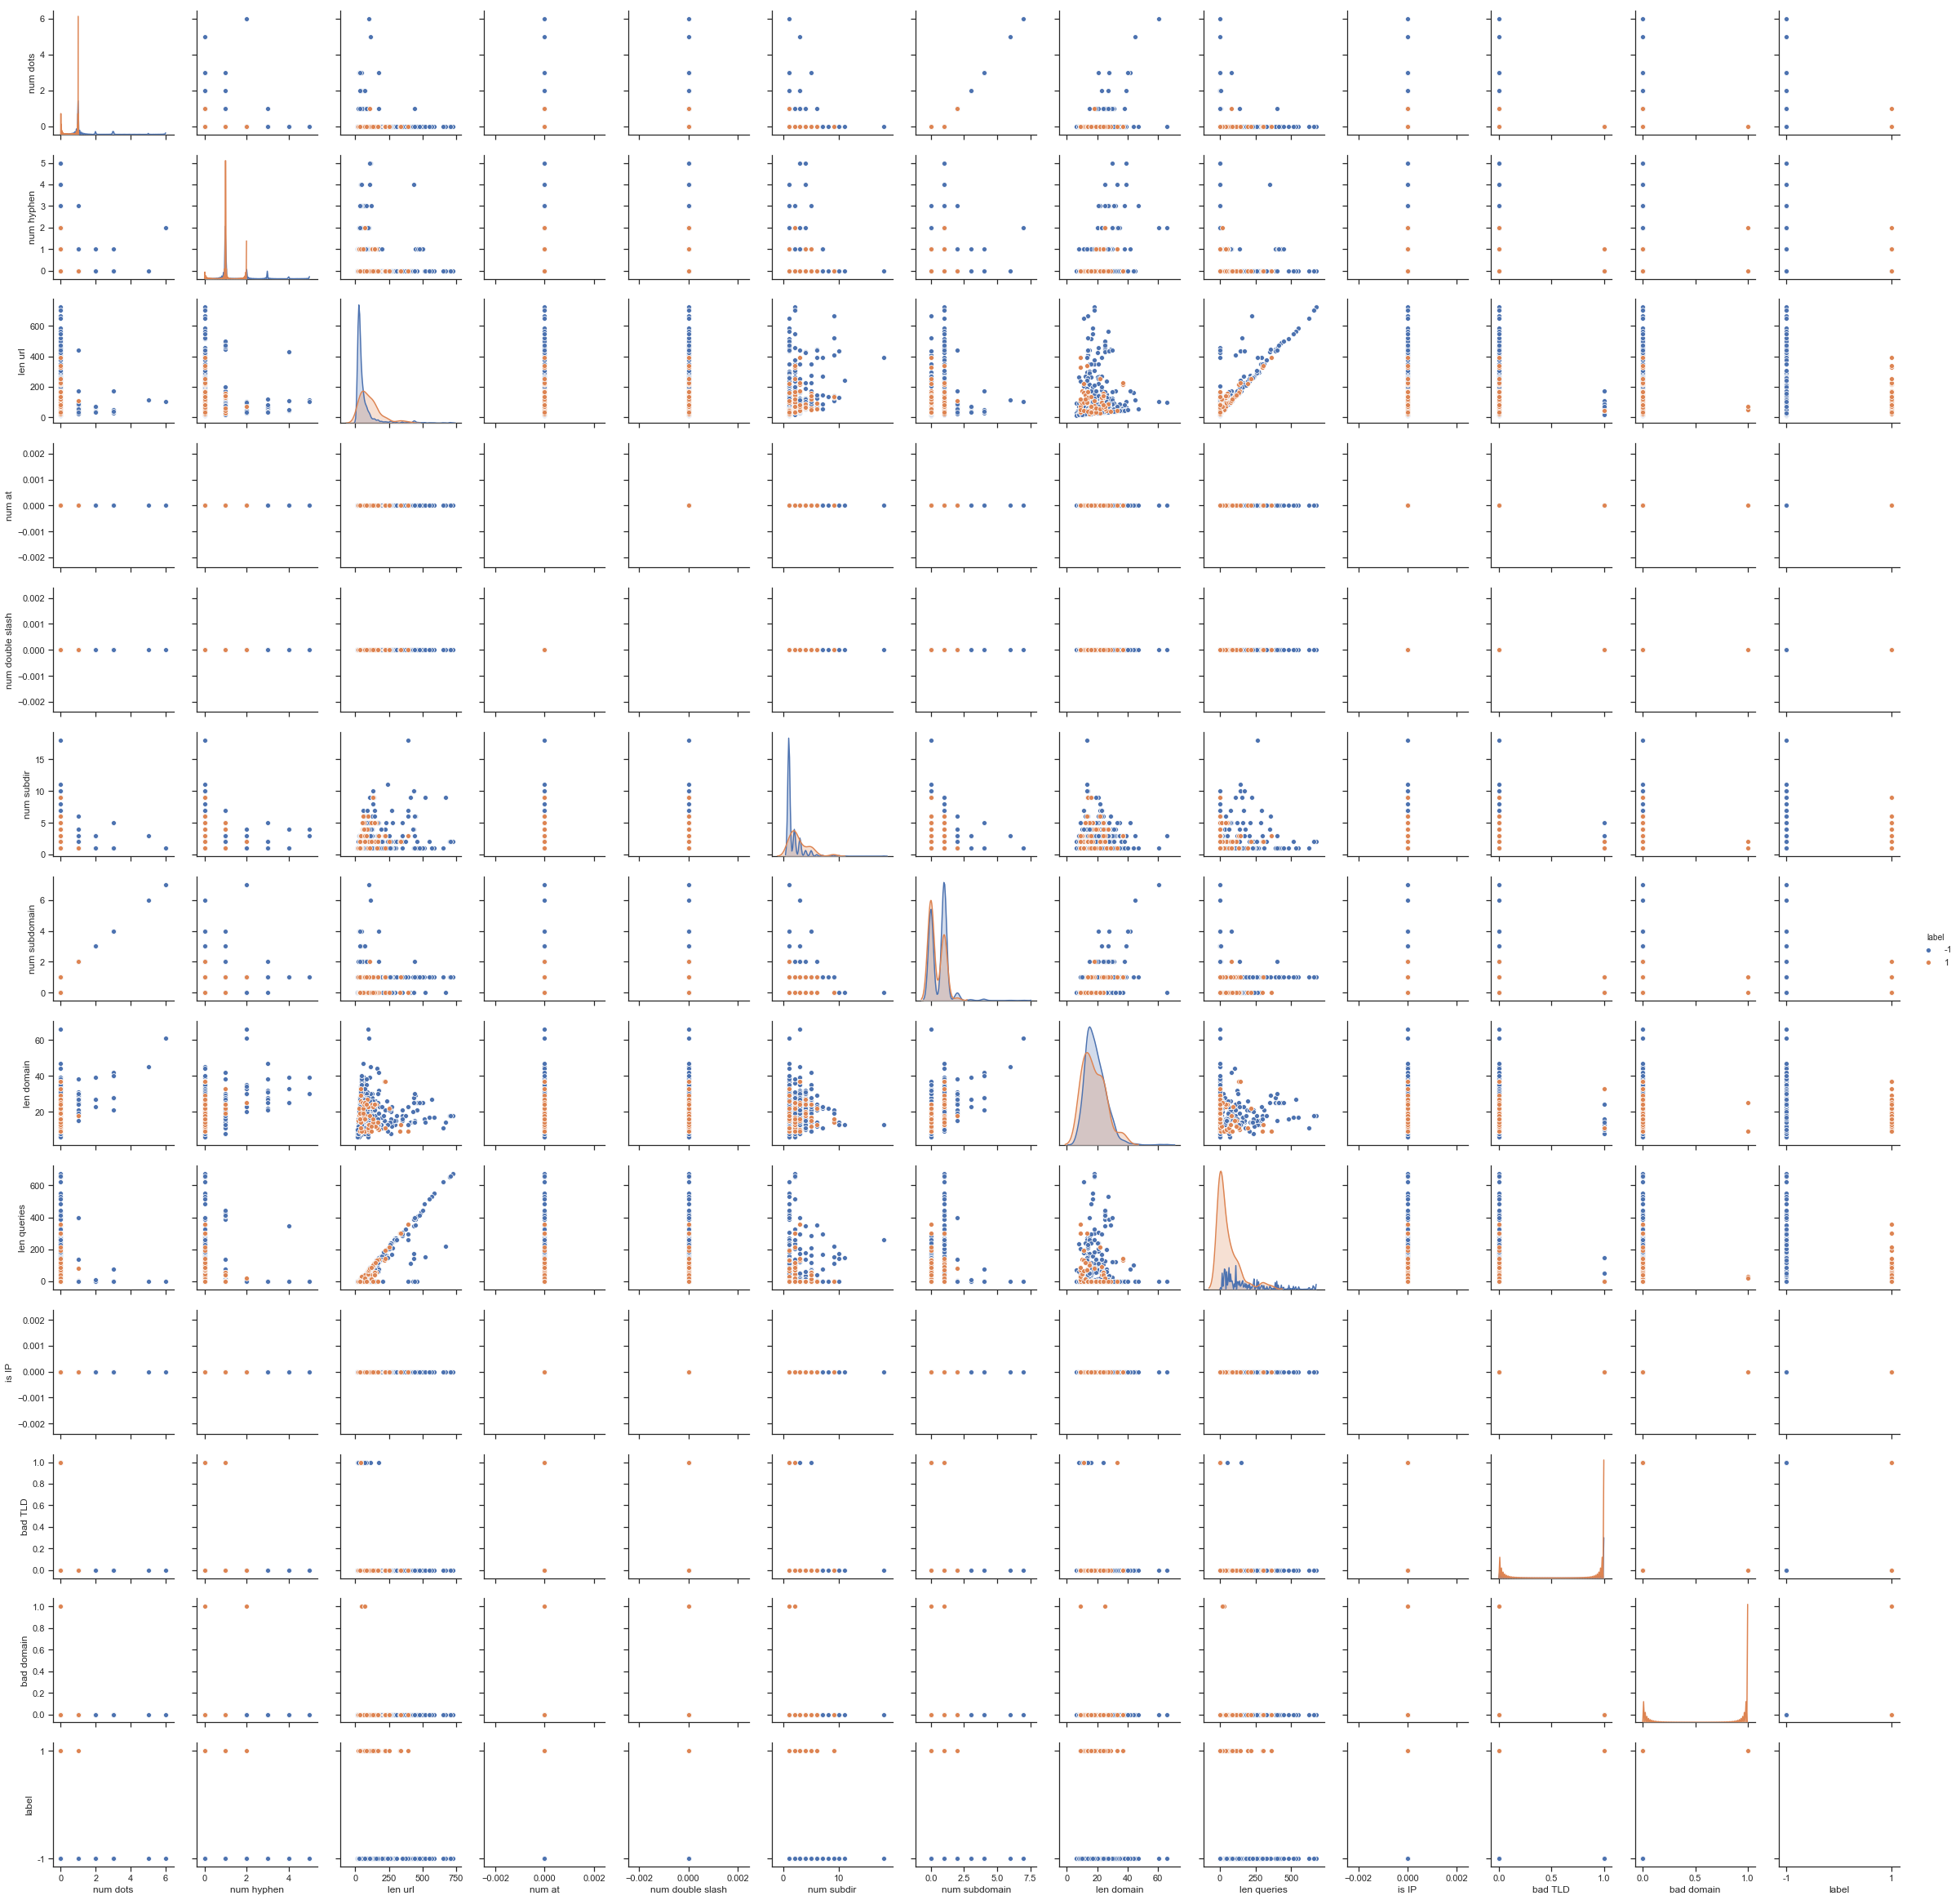

In [23]:
sns.set(style="ticks")
sns_plot = sns.pairplot(df_features, hue="label")
sns_plot.savefig("scatter mat.png")

In [24]:
import sklearn.ensemble as ek
from sklearn import cross_validation, tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

X = df_features.drop(['url','label'],axis=1).values
y = df_features['label'].values

model = { "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
         "RandomForest":ek.RandomForestClassifier(n_estimators=50),
         "Adaboost":ek.AdaBoostClassifier(n_estimators=50),
         "GradientBoosting":ek.GradientBoostingClassifier(n_estimators=50),
         "GNB":GaussianNB(),
         "LogisticRegression":LogisticRegression(),
         "XGBoost":XGBClassifier(n_estimators=50)
}

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

/home/lam/anaconda2/envs/URL712_py3/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/lam/anaconda2/envs/URL712_py3/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

best_model = max(results, key=results.get)
print('Best Classifier: ' + best_model)

/home/lam/anaconda2/envs/URL712_py3/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LogisticRegression : 0.945 
RandomForest : 0.95 
XGBoost : 0.94 
GradientBoosting : 0.955 
GNB : 0.95 
DecisionTree : 0.925 
Adaboost : 0.955 
Best Classifier: GradientBoosting


(2400, 200)
False positive rate : 0.529101 %
False negative rate : 72.727273 %


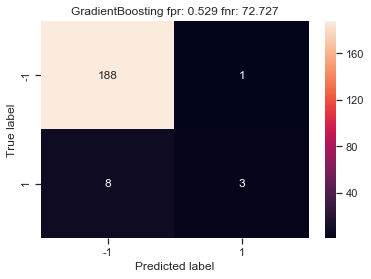

In [26]:
 # confusion matrix
def plot_cm(clf, title, X_test, y_test, ax_ticks):
    predicted_mc = clf.predict(X_test)
    confusion_mc = confusion_matrix(y_test, predicted_mc)
    fpr = ((confusion_mc[0][1] / float(sum(confusion_mc[0])))*100)
    fnr = (confusion_mc[1][0] / float(sum(confusion_mc[1]))*100)
    df_cm = pd.DataFrame(confusion_mc, index = [i for i in range(0,len(ax_ticks))], columns = [i for i in range(0,len(ax_ticks))])

    plt.figure(figsize=(6,4))
    sns.heatmap(df_cm, annot=True, xticklabels=ax_ticks, yticklabels=ax_ticks, fmt='g')
#     plt.title(title + '\nAccuracy:{0:.3f}'.format(accuracy_score(y_test,predicted_mc)))
    plt.title(title + ' fpr: {0:.3f}'.format(fpr) + ' fnr: {0:.3f}'.format(fnr))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

    print("False positive rate : %f %%" % fpr)
    print('False negative rate : %f %%' % fnr)

clf = model[best_model]

print(X_test.size, y_test.size)
plot_cm(clf, best_model, X_test, y_test, ['-1', '1'])
plt.savefig(best_model+" crossval cm1.png")

Run time: 2.963 s
(12000, 1000)
False positive rate : 0.106838 %
False negative rate : 57.812500 %


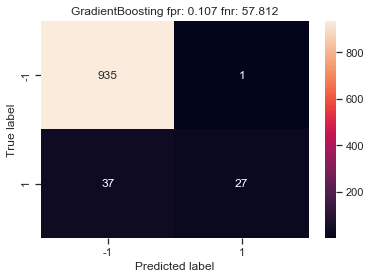

In [27]:
df_test_features = perform_extraction(df_test, features_col)
df_test_features.to_csv("test_features.csv")
X = df_test_features.drop(['url','label'],axis=1).values
y = df_test_features['label'].values
print(X.size, y.size)
plot_cm(clf, best_model, X, y, ['-1', '1'])
plt.savefig(best_model+" test cm2.png")